In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

In [6]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

In [10]:
# Загрузка датасета
data_url = "http://lib.stat.cmu.edu/datasets/boston"
dataframe_raw = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([dataframe_raw.values[::2, :], dataframe_raw.values[1::2, :2]])
target = dataframe_raw.values[1::2, 2]

features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
boston_dataframe = pd.DataFrame(data, columns=features)
boston_dataframe['MEDV'] = target # целевая переменная (ср. стоимость дома в 1000$)

print(f'Размер датасета: {boston_dataframe.shape[0]} x {boston_dataframe.shape[1]}')
print(f'Количество признаков: {len(features)}')

Размер датасета: 506 x 14
Количество признаков: 13


In [12]:
print(boston_dataframe.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [16]:
print(boston_dataframe.describe().round(2))

         CRIM      ZN   INDUS    CHAS     NOX      RM     AGE     DIS     RAD  \
count  506.00  506.00  506.00  506.00  506.00  506.00  506.00  506.00  506.00   
mean     3.61   11.36   11.14    0.07    0.55    6.28   68.57    3.80    9.55   
std      8.60   23.32    6.86    0.25    0.12    0.70   28.15    2.11    8.71   
min      0.01    0.00    0.46    0.00    0.38    3.56    2.90    1.13    1.00   
25%      0.08    0.00    5.19    0.00    0.45    5.89   45.02    2.10    4.00   
50%      0.26    0.00    9.69    0.00    0.54    6.21   77.50    3.21    5.00   
75%      3.68   12.50   18.10    0.00    0.62    6.62   94.07    5.19   24.00   
max     88.98  100.00   27.74    1.00    0.87    8.78  100.00   12.13   24.00   

          TAX  PTRATIO       B   LSTAT    MEDV  
count  506.00   506.00  506.00  506.00  506.00  
mean   408.24    18.46  356.67   12.65   22.53  
std    168.54     2.16   91.29    7.14    9.20  
min    187.00    12.60    0.32    1.73    5.00  
25%    279.00    17.40  3

In [18]:
X = boston_dataframe[features]
y = boston_dataframe['MEDV']
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler() # масштабирование признаков
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {X_train_scaled.shape}')
print(f'Test: {X_test_scaled.shape}')

Train: (404, 13)
Test: (102, 13)


- - - - - - - - -
**Задание №1:**

Построить и отрисовать кривые обучения для любых 2х моделей - регрессорах.

Сделать вывод – какая из моделей более подходит для предложенного датасета,
проанализировать наличие недо- или пере- обученности, выдвинуть предложение о значении целевого показателя выбранной метрики.

Отрисовать целевое значение на построенном графике кривых обучения.

Для одной из моделей отрисовать кривую обучения относительно ошибки.

In [30]:
# Построение кривых обучения
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):

    plt.figure(figsize=(12, 8))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='neg_mean_squared_error', random_state=42) # вычисление кривых
    # MSE -> RMSE (отриц. -> положит.)
    train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
    train_scores_std = np.sqrt(train_scores.std(axis=1))
    test_scores_mean = np.sqrt(-test_scores.mean(axis=1))
    test_scores_std = np.sqrt(test_scores.std(axis=1))
    # Построение графика
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="m")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Ошибка обучения (RMSE)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="m", label="Ошибка валидации (RMSE)")
    best_rmse = 1.33055  # лучший результат
    plt.axhline(y=best_rmse, color='r', linestyle='--', label=f'Целевой RMSE = {best_rmse}', linewidth=2)
    
    plt.xlabel("Размер обучающей выборки")
    plt.ylabel("RMSE")
    plt.title(f"Кривые обучения: {title}")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.show()
    
    # Анализ переобучения или недообучения
    final_train_rmse = train_scores_mean[-1]
    final_test_rmse = test_scores_mean[-1]
    gap = final_test_rmse - final_train_rmse
    print(f"{title}: АНАЛИЗ")
    print(f"RMSE (train): {final_train_rmse:.6f}")
    print(f"RMSE (test): {final_test_rmse:.6f}")
    print(f"Разрыв: {gap:.6f}")
    
    if gap > 2.0:
        # Разрыв между кривыми слишком большой
        print("Переобучение!")
    elif gap < 0.5:
        # Кривые расположены слишком близко
        print("Недообучение...")
    else:
        print("Умеренное обучение.")
    
    return final_train_rmse, final_test_rmse

Линейная регрессия:


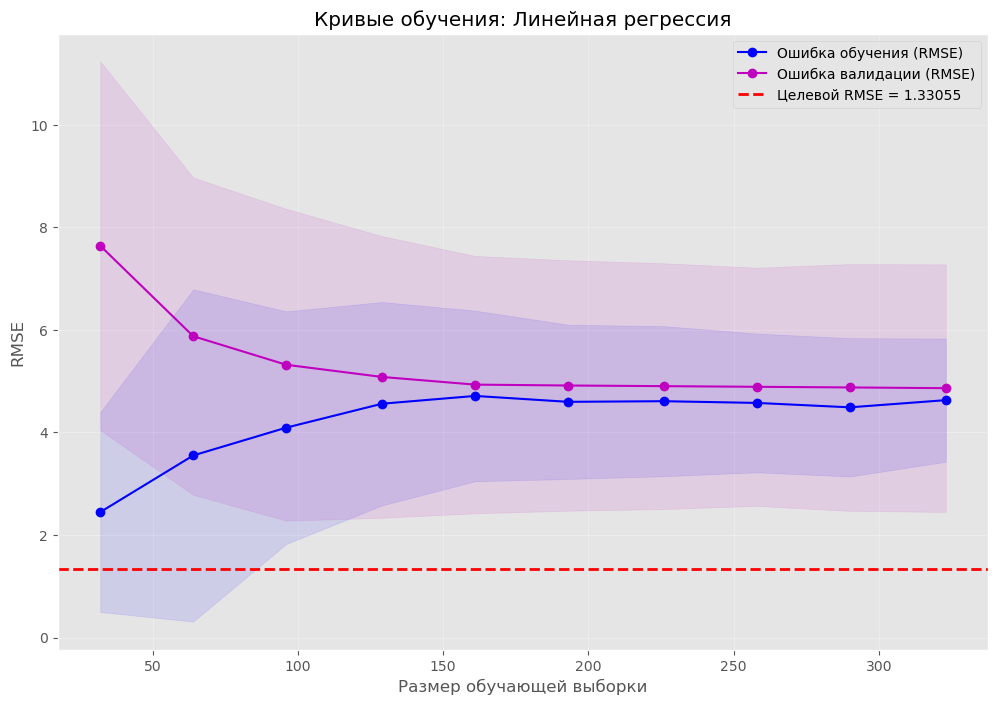

Линейная регрессия: АНАЛИЗ
RMSE (train): 4.629587
RMSE (test): 4.863204
Разрыв: 0.233616
Недообучение...


In [32]:
print('Линейная регрессия:')

linear_model = LinearRegression()
train_rmse_lin, test_rmse_lin = plot_learning_curve(linear_model, "Линейная регрессия", X_train_scaled, y_train, cv=5)

Ridge регрессия:


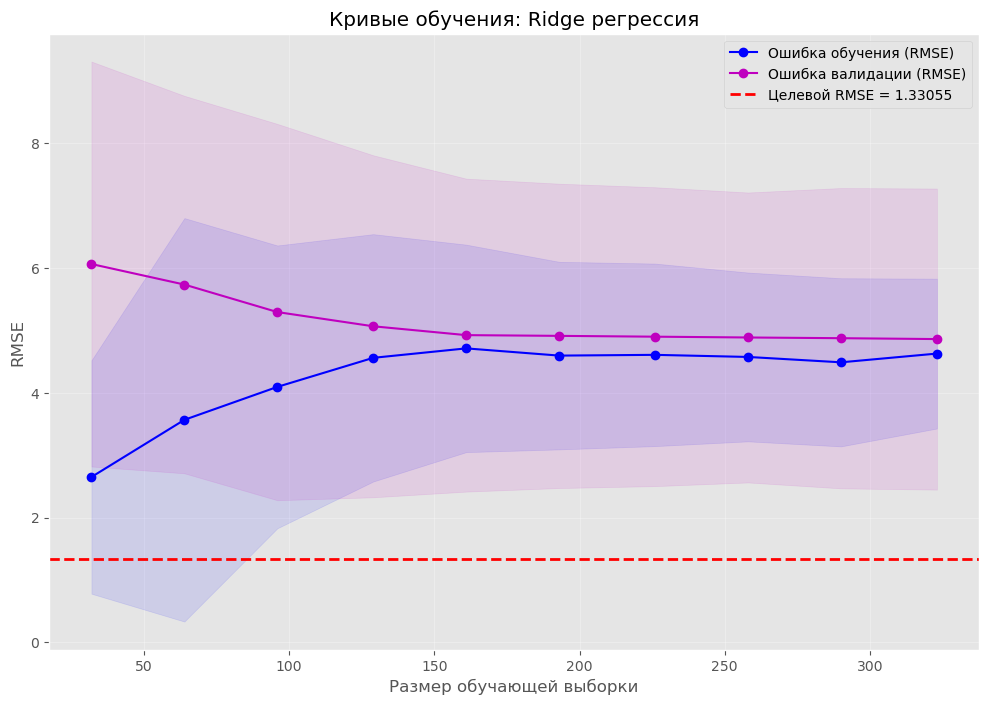

Ridge регрессия: АНАЛИЗ
RMSE (train): 4.629808
RMSE (test): 4.862618
Разрыв: 0.232810
Недообучение...


In [34]:
print('Ridge регрессия:')

ridge_model = Ridge(alpha=1.0)
train_rmse_ridge, test_rmse_ridge = plot_learning_curve(ridge_model, "Ridge регрессия", X_train_scaled, y_train, cv=5)

**Вывод:** 
Модели ведут себя приблизительно одинаково, обе из них не показывают переобучения. Для гребневой регуляризации разрыв оказался немного меньше, чем для линейной регрессии => она недообучилась сильнее. 

- - - - - - - -
**Задание №2:**

Последовательно выполнить обучение моделей линейной регрессии, гребневой регуляризации (Ridge)  и Lasso регуляризации. 

Сравнить модели используя несколько метрик.

Свести значения весовых коэффициентов в единую таблицу, сделать выводы о коллинеарности данных и о важности имеющихся признаков.

In [ ]:
# Оценка модели
def evaluation(model, model_name, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train) # обучение
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    metrics = {
        'Модель': model_name,
        'R^2 (train)': r2_score(y_train, y_train_predict),
        'R^2 (test)': r2_score(y_test, y_test_predict),
        'MAE (train)': mean_absolute_error(y_train, y_train_predict),
        'MAE (test)': mean_absolute_error(y_test, y_test_predict),
        'MSE (train)': mean_squared_error(y_train, y_train_predict),
        'MSE (test)': mean_squared_error(y_test, y_test_predict),
        'RMSE (train)': np.sqrt(mean_squared_error(y_train, y_train_predict)),
        'RMSE (test)': np.sqrt(mean_squared_error(y_test, y_test_predict))
    }
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error') # кросс-валидация
    metrics['CV MSE'] = -cv_scores.mean()
    metrics['CV RMSE'] = np.sqrt(-cv_scores.mean())
    
    return metrics, model.coef_ if hasattr(model, 'coef_') else None

In [72]:
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1, max_iter=10000)
}
results = []
coefficients = {}

for name, model in models.items():
    metrics, coef = evaluation(model, name, X_train_scaled, X_test_scaled, y_train, y_test)
    results.append(metrics)
    if coef is not None:
        coefficients[name] = coef

In [74]:
# Таблица результатов
results_df = pd.DataFrame(results)
print(results_df.round(4).to_string())

   Модель  R^2 (train)  R^2 (test)  MAE (train)  MAE (test)  MSE (train)  MSE (test)  RMSE (train)  RMSE (test)   CV MSE  CV RMSE
0  Linear       0.7509      0.6688       3.3148      3.1891      21.6414     24.2911        4.6520       4.9286  23.6544   4.8636
1   Ridge       0.7509      0.6685       3.3087      3.1857      21.6428     24.3129        4.6522       4.9308  23.6488   4.8630
2   Lasso       0.7450      0.6501       3.2658      3.2418      22.1495     25.6567        4.7063       5.0652  24.2041   4.9198


In [68]:
# Таблица весовых коэффициентов
coefficients_df = pd.DataFrame(coefficients, index=features)
print(coefficients_df.round(4).to_string())

         Linear   Ridge   Lasso
CRIM    -1.0021 -0.9922 -0.7184
ZN       0.6963  0.6777  0.2596
INDUS    0.2781  0.2522 -0.0000
CHAS     0.7187  0.7225  0.6982
NOX     -2.0223 -1.9908 -1.5681
RM       3.1452  3.1516  3.2715
AGE     -0.1760 -0.1773 -0.0000
DIS     -3.0819 -3.0450 -2.2844
RAD      2.2514  2.1732  0.6719
TAX     -1.7670 -1.6956 -0.3567
PTRATIO -2.0378 -2.0278 -1.8933
B        1.1296  1.1272  1.0314
LSTAT   -3.6117 -3.5990 -3.6094


In [94]:
# Анализ коллинеарности
corr_matrix = X.corr()
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8: # Высокая корреляция
            print("Пара признаков с высокой корреляцией (выше 0.8):")
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
            print(f"{corr_matrix.columns[i]} - {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.4f}")
if not high_corr_pairs:
    print("Пары с высокой корреляцией признаков не найдены...")

Пара признаков с высокой корреляцией (выше 0.8):
RAD - TAX: 0.9102


In [122]:
# Анализ стабильности коэффициентов
coef_variability = coefficients_df.std(axis=1)
coef_variability_df = pd.DataFrame({
    'Признак': features,
    'Стандартное отклонение': coef_variability.values
}).sort_values('Стандартное отклонение', ascending=False)

print(coef_variability_df.round(4).to_string(index=False))

Признак  Стандартное отклонение
    RAD                  0.8902
    TAX                  0.7944
    DIS                  0.4501
    NOX                  0.2536
     ZN                  0.2469
   CRIM                  0.1610
  INDUS                  0.1536
    AGE                  0.1020
PTRATIO                  0.0807
     RM                  0.0711
      B                  0.0560
   CHAS                  0.0131
  LSTAT                  0.0068


Чем меньше стандартное отклонение, тем более стабильным является коэффициент.

In [143]:
# Анализ важности признаков
mean_abs_coef = pd.DataFrame({
    'Признак': features,
    'Средний коэффициент': np.abs(coefficients_df.mean(axis=1))
}).sort_values('Средний коэффициент', ascending=False)

print(mean_abs_coef.round(4).to_string())

         Признак  Средний коэффициент
LSTAT      LSTAT               3.6067
RM            RM               3.1894
DIS          DIS               2.8038
PTRATIO  PTRATIO               1.9863
NOX          NOX               1.8604
RAD          RAD               1.6989
TAX          TAX               1.2731
B              B               1.0960
CRIM        CRIM               0.9042
CHAS        CHAS               0.7131
ZN            ZN               0.5445
INDUS      INDUS               0.1768
AGE          AGE               0.1178


Чем больше среднее абсолютное значение коэффициента, тем более важным он является.

- - - - - - - -
**Задание №3:**
Попытаться реализовать ElasticNet модель. Сравнить с результатами полученными в п.2.

In [166]:
# Попытки подобрать параметры для лучшего результата
# l1_ratio: 0 => Ridge, 1 => Lasso
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
elastic_net = ElasticNet(max_iter=10000, random_state=42)
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search.fit(X_train_scaled, y_train)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая MSE: {-grid_search.best_score_:.6f}")

Лучшие параметры: {'alpha': 0.01, 'l1_ratio': 0.1}
Лучшая MSE: 23.649678


In [173]:
# Обучение
elastic_net = grid_search.best_estimator_
elastic_net_metrics, elastic_net_coef = evaluation(elastic_net, "ElasticNet", X_train_scaled, X_test_scaled, y_train, y_test)

In [175]:
# Добавление в таблицы результатов
results.append(elastic_net_metrics)
coefficients["ElasticNet"] = elastic_net_coef
final_results_df = pd.DataFrame(results)

print(final_results_df.round(4).to_string())

       Модель  R^2 (train)  R^2 (test)  MAE (train)  MAE (test)  MSE (train)  MSE (test)  RMSE (train)  RMSE (test)   CV MSE  CV RMSE
0      Linear       0.7509      0.6688       3.3148      3.1891      21.6414     24.2911        4.6520       4.9286  23.6544   4.8636
1       Ridge       0.7509      0.6685       3.3087      3.1857      21.6428     24.3129        4.6522       4.9308  23.6488   4.8630
2       Lasso       0.7450      0.6501       3.2658      3.2418      22.1495     25.6567        4.7063       5.0652  24.2041   4.9198
3  ElasticNet       0.7507      0.6676       3.2956      3.1796      21.6587     24.3743        4.6539       4.9370  23.6497   4.8631


In [181]:
coefficients_compare = pd.DataFrame({
    'Признак': features,
    'Ridge': coefficients['Ridge'],
    'Lasso': coefficients['Lasso'],
    f"ElasticNet": coefficients['ElasticNet'],
    '(Ridge - ElasticNet)': coefficients['Ridge'] - coefficients['ElasticNet'],
    '(Lasso - ElasticNet)': coefficients['Lasso'] - coefficients['ElasticNet']
})

print(coefficients_compare.round(4).to_string(index=False))

Признак   Ridge   Lasso  ElasticNet  (Ridge - ElasticNet)  (Lasso - ElasticNet)
   CRIM -0.9922 -0.7184     -0.9658               -0.0264                0.2474
     ZN  0.6777  0.2596      0.6295                0.0482               -0.3699
  INDUS  0.2522 -0.0000      0.1838                0.0684               -0.1838
   CHAS  0.7225  0.6982      0.7312               -0.0087               -0.0330
    NOX -1.9908 -1.5681     -1.9069               -0.0840                0.3387
     RM  3.1516  3.2715      3.1660               -0.0144                0.1055
    AGE -0.1773 -0.0000     -0.1775                0.0003                0.1775
    DIS -3.0450 -2.2844     -2.9463               -0.0987                0.6618
    RAD  2.1732  0.6719      1.9757                0.1976               -1.3038
    TAX -1.6956 -0.3567     -1.5171               -0.1785                1.1604
PTRATIO -2.0278 -1.8933     -2.0014               -0.0264                0.1081
      B  1.1272  1.0314      1.1199     

**Вывод:** ElasticNet с подобранными параметрами показывает результаты, находящиеся где-то между Ridge и Lasso.